In [1]:
# Step 1: Import required libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt


In [2]:
# Generate synthetic data: small 28x28 "parts"
def generate_data(n_samples=100):
    x = np.random.rand(n_samples, 28, 28, 1)
    labels = np.random.randint(0, 2, n_samples)
    return x, labels

x_data, y_data = generate_data(200)

# Create image pairs (same/different)
def make_pairs(x, labels):
    pairs = []
    pair_labels = []
    for i in range(len(x)):
        # Positive pair
        idx_same = np.random.choice(np.where(labels == labels[i])[0])
        pairs.append([x[i], x[idx_same]])
        pair_labels.append(1)

        # Negative pair
        idx_diff = np.random.choice(np.where(labels != labels[i])[0])
        pairs.append([x[i], x[idx_diff]])
        pair_labels.append(0)
    return np.array(pairs), np.array(pair_labels)

pairs, pair_labels = make_pairs(x_data, y_data)

print("Pairs shape:", pairs.shape)
print("Labels shape:", pair_labels.shape)


Pairs shape: (400, 2, 28, 28, 1)
Labels shape: (400,)


In [3]:
def build_base_network():
    inputs = keras.Input(shape=(28, 28, 1))
    x = layers.Conv2D(16, (3, 3), activation="relu")(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(32, (3, 3), activation="relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="relu")(x)
    return keras.Model(inputs, x, name="base_network")

base_network = build_base_network()
base_network.summary()


Model: "base_network"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 26, 26, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3872)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       247,872 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 252,672 (987.00 KB)

 Trainable params: 252,672 (987.00 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
input_a = keras.Input(shape=(28, 28, 1))
input_b = keras.Input(shape=(28, 28, 1))

feat_a = base_network(input_a)
feat_b = base_network(input_b)

# Compute absolute difference
distance = layers.Lambda(lambda x: tf.abs(x[0] - x[1]))([feat_a, feat_b])
output = layers.Dense(1, activation="sigmoid")(distance)

siamese_net = keras.Model([input_a, input_b], output)
siamese_net.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ base_network        │ (None, 64)        │    252,672 │ input_layer_1[0]… │
│ (Functional)        │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 64)        │          0 │ base_network[0][… │
│                     │                   │            │ base_network[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ lambda[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 252,737 (987.25 KB)

 Trainable params: 252,737 (987.25 KB)

 Non-trainable params: 0 (0.00 B)

In [5]:
siamese_net.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = siamese_net.fit(
    [pairs[:, 0], pairs[:, 1]],
    pair_labels,
    batch_size=16,
    epochs=5,
    validation_split=0.2
)


Epoch 1/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.4889 - loss: 0.6945 - val_accuracy: 0.4625 - val_loss: 0.6929
Epoch 2/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8528 - loss: 0.6474 - val_accuracy: 0.4625 - val_loss: 0.6954
Epoch 3/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9293 - loss: 0.5982 - val_accuracy: 0.5125 - val_loss: 0.6942
Epoch 4/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9735 - loss: 0.5242 - val_accuracy: 0.5375 - val_loss: 0.7009
Epoch 5/5
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9767 - loss: 0.4043 - val_accuracy: 0.5125 - val_loss: 0.7277


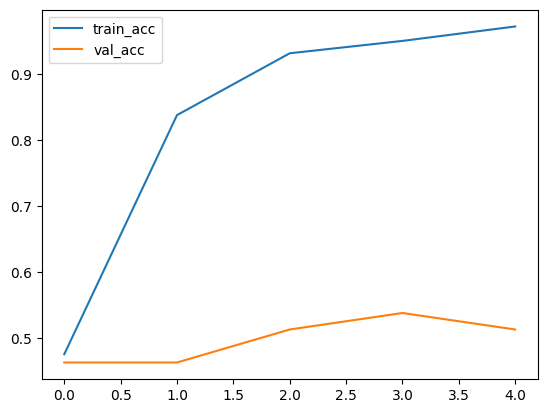

In [6]:
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 690ms/step


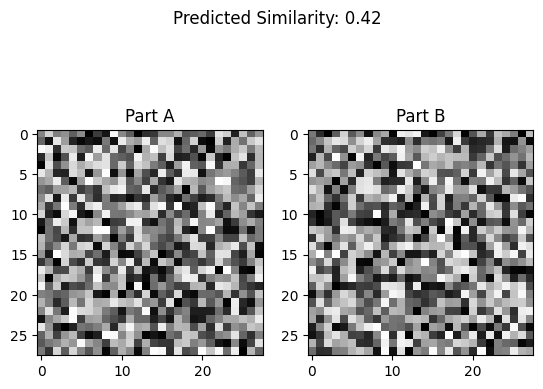

In [7]:
idx = np.random.randint(0, len(pairs))
img1, img2 = pairs[idx]
pred = siamese_net.predict([img1[np.newaxis, ...], img2[np.newaxis, ...]])[0][0]

plt.subplot(1,2,1)
plt.imshow(img1.squeeze(), cmap='gray')
plt.title("Part A")

plt.subplot(1,2,2)
plt.imshow(img2.squeeze(), cmap='gray')
plt.title("Part B")

plt.suptitle(f"Predicted Similarity: {pred:.2f}")
plt.show()
